# <font color='Tomato'>Planejamento da Solução (IOT)</font>

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade "INSIDERS"
2. Conjunto de dados com as vendas de produtos durantes 1 ano (11/2015 - 12/2017)

## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
2. Relatório com as respostas das perguntas de negocio.

## Tasks - Processo

# 0.0. Imports

In [271]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import umap.umap_ as umap

from IPython.display import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn import cluster
from sklearn import metrics
from sklearn import preprocessing as pp

## 0.1. Helper Functions

In [272]:
def descriptive_statistics(num_attr):
    # Central Tendency: mean, median
    c1 = pd.DataFrame(num_attr.apply(np.mean))
    c2 = pd.DataFrame(num_attr.apply(np.median))

    # Dispension: min, max, range, std, skew, kurtosis
    d1 = pd.DataFrame(num_attr.apply(min))
    d2 = pd.DataFrame(num_attr.apply(max))
    d3 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min()))
    d4 = pd.DataFrame(num_attr.apply(lambda x: x.std()))
    
    # Measures of Shape
    s1 = pd.DataFrame(num_attr.apply(lambda x: x.skew()))
    s2 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis()))

    # concat
    m = pd.concat([d1,d2,d3,c1,c2,d4,s1,s2], axis=1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Load Data

In [273]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1.0. Data Description

In [274]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [275]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimnesions

In [276]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3. Data Types

In [277]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [278]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [279]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [280]:
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge 
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)

In [281]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [282]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [283]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7. Descriptive Statistics

In [284]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(include=['object'])

## 1.7.1. Numerical Attributes

In [285]:
descriptive_statistics(num_att)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
1,unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72
2,customer_id,12346.00,22709.00,10363.00,16688.84,16249.00,2911.41,0.49,-0.80


**Notes:**
    
1. quantity: numero negativo e alto, pode ser retorno
2. unit_price: zero unidades? 

## 1.7.2. Categorical Attributes

In [286]:
cat_att.describe(include=['O'])

,invoice_no,stock_code,description,country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


### invoice_no

In [287]:
list_letter_invoice = df1.loc[~df1['invoice_no'].apply(lambda x: bool(re.search(r'^[0-9]+', x))), 'invoice_no'].tolist()
len(list_letter_invoice)

9291

In [288]:
list_letter_invoice[:10]

['C536379',
 'C536383',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536506']

### stock_code

In [289]:
list_letter_stock_code = df1.loc[~df1['stock_code'].apply(lambda x: bool(re.search(r'[^a-zA-Z]+$', x))), 'stock_code'].tolist()

len(list_letter_stock_code)

54675

### country

In [290]:
df1['country'].value_counts(normalize=True).head(10)

United Kingdom   0.91
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.00
Netherlands      0.00
Belgium          0.00
Switzerland      0.00
Portugal         0.00
Australia        0.00
Name: country, dtype: float64

**Notes**
1. invoice_no: 8905 items que não são somente numeros.
2. stock_code: 35809 items que não são somente numeros.
3. description: não tem informação relevante.

# 2.0. Data Filtering

In [291]:
df2 = df1.copy()

## 2.1. Filter Columns

In [292]:
cols_drop = ['description']
df2 = df2.drop(cols_drop, axis=1)

## 2.2. Filter Rows

In [293]:
# Numerical Attributes
df2 = df2.loc[df2['unit_price'] >= 0.4, :]

# Categorical Attributes
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ), :]

# map
df2 = df2.loc[~df2['country'].isin(['European Community', 'Unspecified' ]), :]

# bad user
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns   = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [294]:
df3 = df2.copy()

## 3.1. Feature Creation

In [295]:
drop_cols = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']
df_ref = df3.drop(drop_cols, axis=1).drop_duplicates(ignore_index=True)

In [296]:
df2_purchases.loc[:, ['gross_revenue']] = (df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price'])

/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### 3.1.1. Monetary

In [297]:
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index().rename(columns={'gross_revenue': 'monetary'})
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id     0
monetary       92
dtype: int64

### 3.1.2. Recency

In [298]:
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id      0
monetary        92
recency_days    92
dtype: int64

### 3.1.3. Quatily of purchased

In [299]:
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().\
rename(columns={'invoice_no': 'qtde_invoices'})

df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
monetary         92
recency_days     92
qtde_invoices    92
dtype: int64

### 3.1.4. Quantity total of items purchased

In [300]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id')
                                                            .sum()
                                                            .reset_index()
                                                            .rename(columns={'quantity': 'qtde_items'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
monetary         92
recency_days     92
qtde_invoices    92
qtde_items       92
dtype: int64

### 3.1.5. Quantity of products purchased

In [301]:
df_freq = ( df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id')
                                                               .count()
                                                               .reset_index()
                                                               .rename(columns={'stock_code': 'qtde_products'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
monetary         92
recency_days     92
qtde_invoices    92
qtde_items       92
qtde_products    92
dtype: int64

### 3.1.6. Average Ticket

In [302]:
df_avg_ticket =  (df2_purchases.loc[:, ['customer_id','gross_revenue']].groupby('customer_id')
                                                                       .mean()
                                                                       .reset_index()
                                                                       .rename(columns={'gross_revenue': 'avg_ticket'}))

df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
monetary         92
recency_days     92
qtde_invoices    92
qtde_items       92
qtde_products    92
avg_ticket       92
dtype: int64

### 3.1.7. Average Recency Days

In [303]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previus_date'] = df_aux['invoice_date'].shift()

In [304]:
df_aux['avg_recency_days'] = df_aux.apply( lambda x: (x['invoice_date'] - x['previus_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)
df_aux = df_aux.drop(columns=['invoice_date', 'next_customer_id', 'previus_date'], axis=1).dropna()

In [305]:
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
monetary              92
recency_days          92
qtde_invoices         92
qtde_items            92
qtde_products         92
avg_ticket            92
avg_recency_days    2815
dtype: int64

### 3.1.8. Frequency Purchase

In [306]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                 .groupby('customer_id')
                                                 .agg( max_ = ('invoice_date', 'max'),
                                                       min_ = ('invoice_date', 'min'),
                                                       days = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1 ),
                                                       buy_ = ( 'invoice_no', 'count' ))).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days']].apply( lambda x: x['buy_'] / x['days'] if x['days'] != 0 else 0, axis=1 )

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
monetary              92
recency_days          92
qtde_invoices         92
qtde_items            92
qtde_products         92
avg_ticket            92
avg_recency_days    2815
frequency             92
dtype: int64

### 3.1.9. Number Or Returns

In [307]:
df_returns = df2_returns[['quantity', 'customer_id']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref['qtde_returns'].fillna(0, inplace=True)
df_ref.isna().sum()

customer_id            0
monetary              92
recency_days          92
qtde_invoices         92
qtde_items            92
qtde_products         92
avg_ticket            92
avg_recency_days    2815
frequency             92
qtde_returns           0
dtype: int64

### 3.1.10. Basket Size

In [308]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                   .agg( n_purchase=('invoice_no', 'nunique'),
                                                                         n_products=('quantity', 'sum'))).reset_index()
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']
df_ref = pd.merge(df_ref, df_aux[['avg_basket_size', 'customer_id']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
monetary              92
recency_days          92
qtde_invoices         92
qtde_items            92
qtde_products         92
avg_ticket            92
avg_recency_days    2815
frequency             92
qtde_returns           0
avg_basket_size       92
dtype: int64

### 3.1.11. Unique Basket Size

In [309]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('stock_code', 'nunique'))).reset_index()
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_ref = pd.merge(df_ref, df_aux[['avg_unique_basket_size', 'customer_id']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
monetary                    92
recency_days                92
qtde_invoices               92
qtde_items                  92
qtde_products               92
avg_ticket                  92
avg_recency_days          2815
frequency                   92
qtde_returns                 0
avg_basket_size             92
avg_unique_basket_size      92
dtype: int64

# 4.0. EDA  

In [310]:
df_ref = df_ref.dropna()

df4 = df_ref.copy()

# 5.0. Data Preparation 

In [311]:
df5 = df4.copy()

In [312]:
ss = pp.StandardScaler()

df5['monetary'] = ss.fit_transform(df5[['monetary']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['qtde_invoices'] = ss.fit_transform(df5[['qtde_invoices']])
df5['qtde_items'] = ss.fit_transform(df5[['qtde_items']])
df5['qtde_products'] = ss.fit_transform(df5[['qtde_products']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['qtde_returns'] = ss.fit_transform(df5[['qtde_returns']])
df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])

# 6.0. Feature Selection

In [313]:
df6 = df5.copy()

# 7.0. Hyperpameter Fine Tuning

In [314]:
X = df6.drop(columns=['customer_id'])

X.head()

,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.27,3.96,3.21,0.07,0.69,-0.12,0.50,41.43,0.03,-0.61,-1.09
1,0.06,-0.11,0.37,0.00,0.20,-0.12,0.63,-0.21,0.01,-0.20,-0.34
2,0.39,-0.80,1.05,0.48,0.40,-0.03,0.69,-0.18,0.06,0.19,-0.65
3,-0.17,0.40,-0.08,-0.19,-0.35,0.01,-0.40,-0.23,-0.12,-0.49,-0.82
4,-0.18,3.45,-0.31,-0.26,-0.44,2.16,0.92,-0.10,-0.04,-0.71,-1.11


In [315]:
clusters = [2,3,4,5,6,7]

## KMeans

/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/cid/.pyenv/versions/3.8.0/envs/clustering-high-value-customers-identification/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


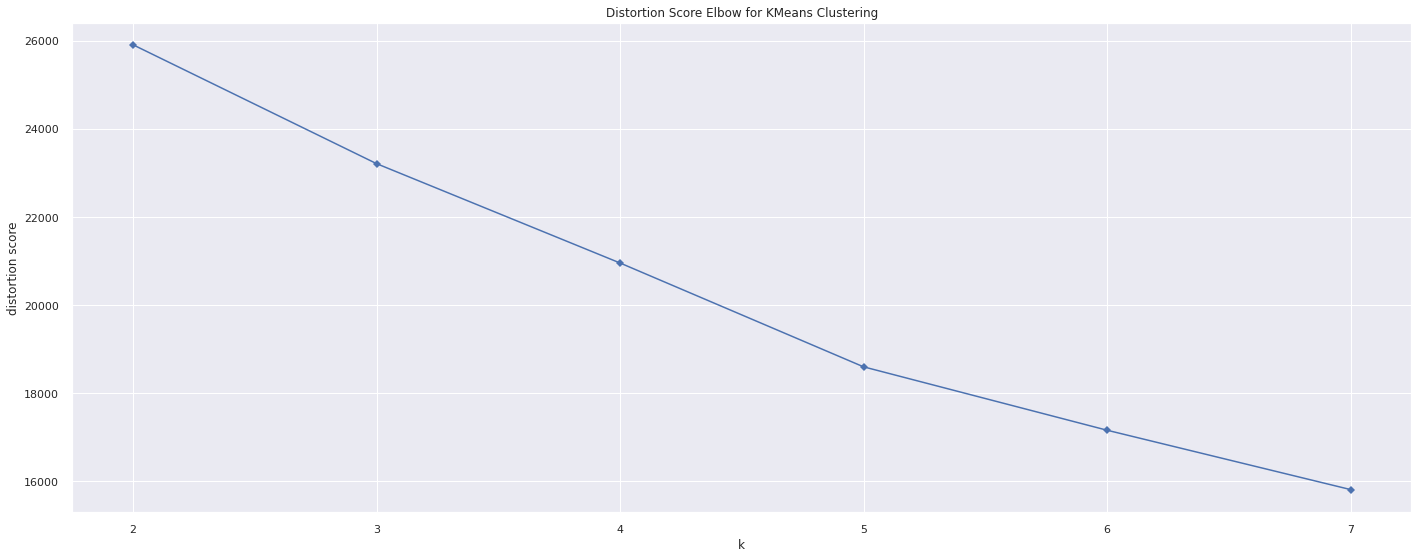

In [316]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show();

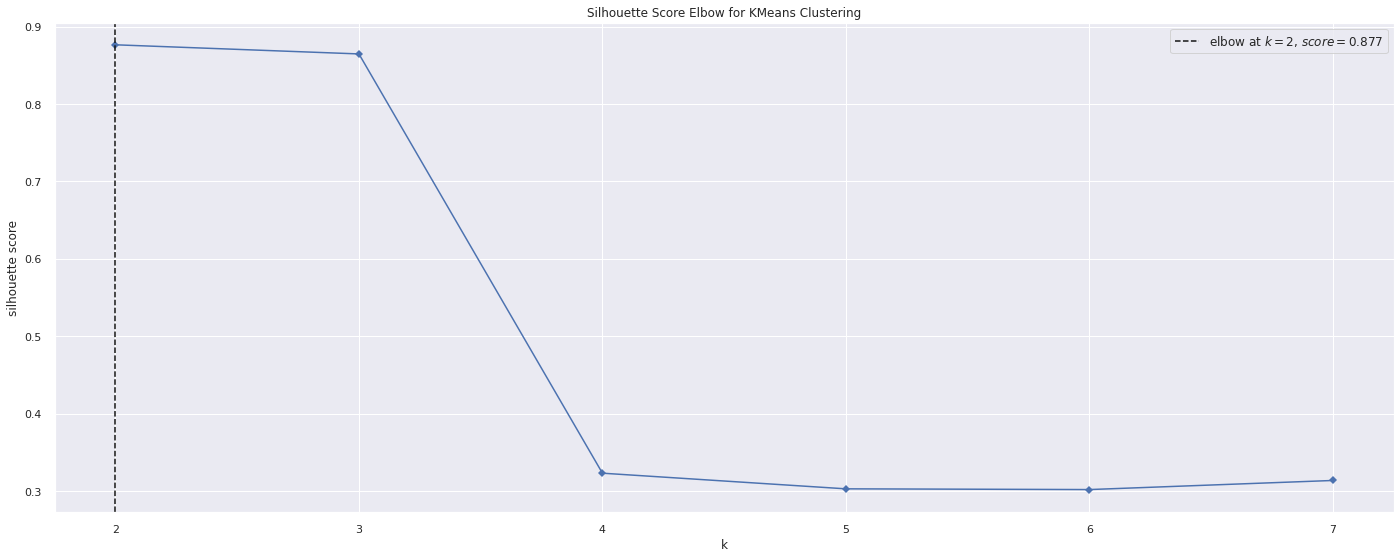

In [317]:
km = KElbowVisualizer(cluster.KMeans(), k=clusters, metric='silhouette', timings=False)
km.fit( X )
km.show();

## 7.1. Silhouette Analysis

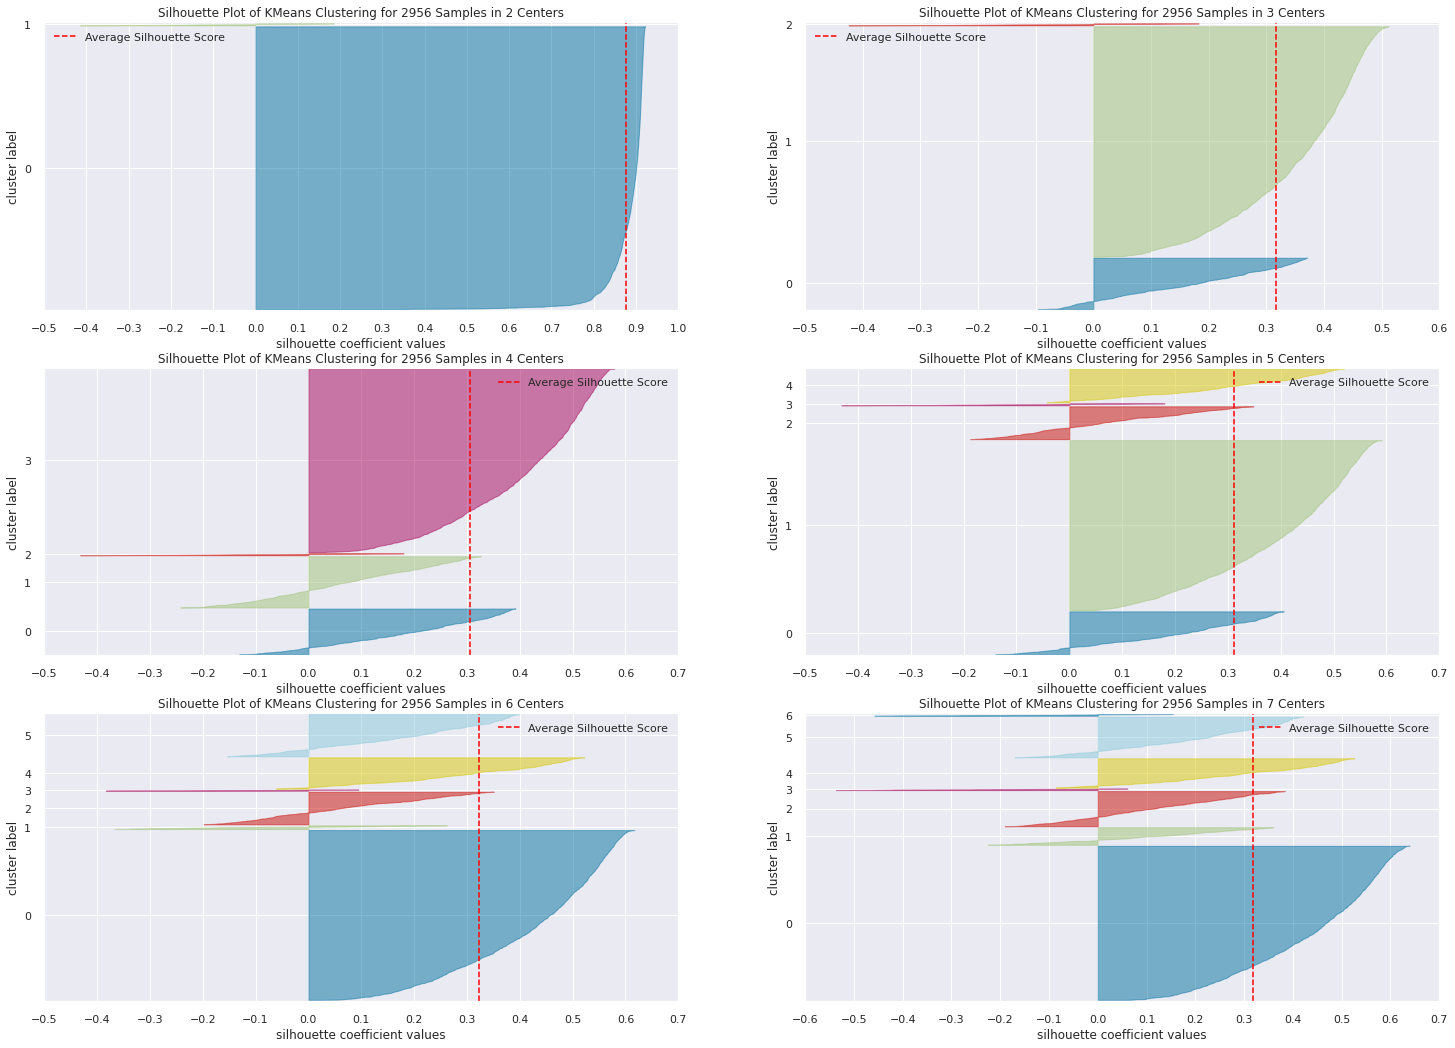

In [318]:
fig, ax = plt.subplots(3,2, figsize=(25, 18))

for k in clusters:
    km = cluster.KMeans(n_clusters=k, init='random', n_init=10, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize();

# 8.0. Model Training

## 8.1. K-Means

In [319]:
# model definition
k = 3
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [320]:
print('WSS value: {}'.format( kmeans.inertia_ ))
print('SS value: {}'.format( metrics.silhouette_score(X, labels, metric='euclidean') ))

WSS value: 23337.603925859697
SS value: 0.3175184946170052


# 9.0. Cluster Analysis

In [328]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,-35.50,17.00,40.00,50.97,0.62,1
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,-27.25,0.03,35.00,154.44,11.67,2
2,12583,6495.30,2.00,15.00,3796.00,221.00,29.39,-23.19,0.04,50.00,253.07,7.13,2
3,13748,938.89,95.00,5.00,415.00,27.00,34.77,-92.67,0.02,0.00,83.00,4.60,2
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,-8.60,0.07,22.00,26.67,0.33,1


## 9.1. Visualization Inspection

### 9.1.1. Silhouette Analysis

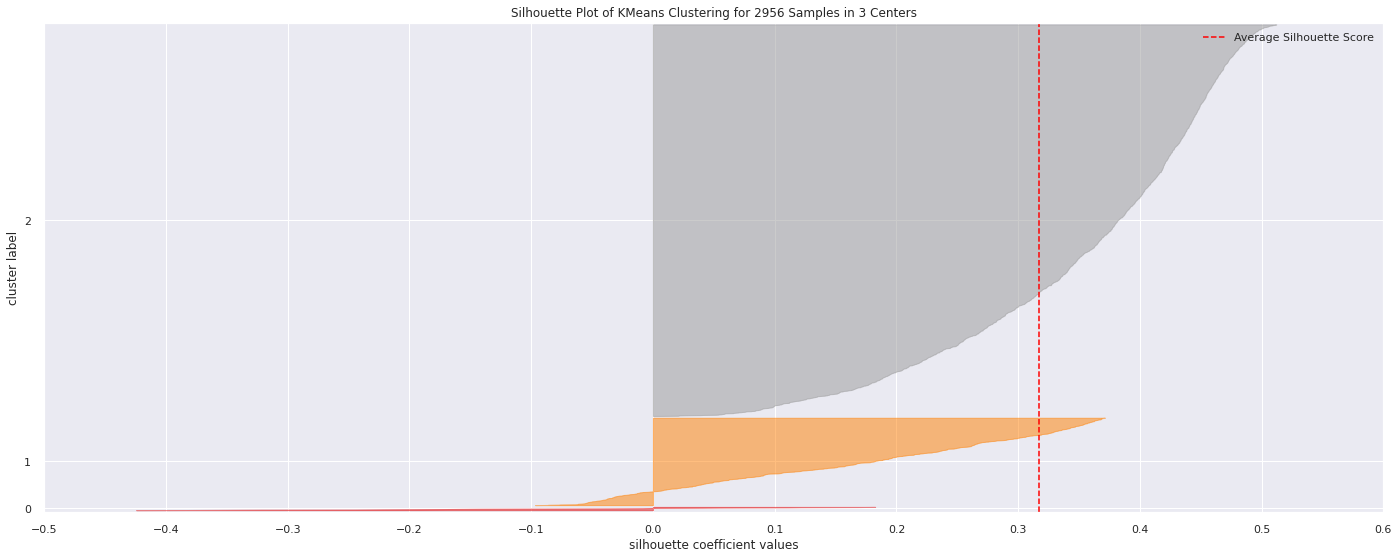

In [322]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit( X )
visualizer.finalize();

### 9.1.2 2d plot

In [323]:
df_viz = df9.drop(columns='customer_id')

In [324]:
# sns.pairplot(df_viz, hue='cluster');

### 9.1.3. UMAP

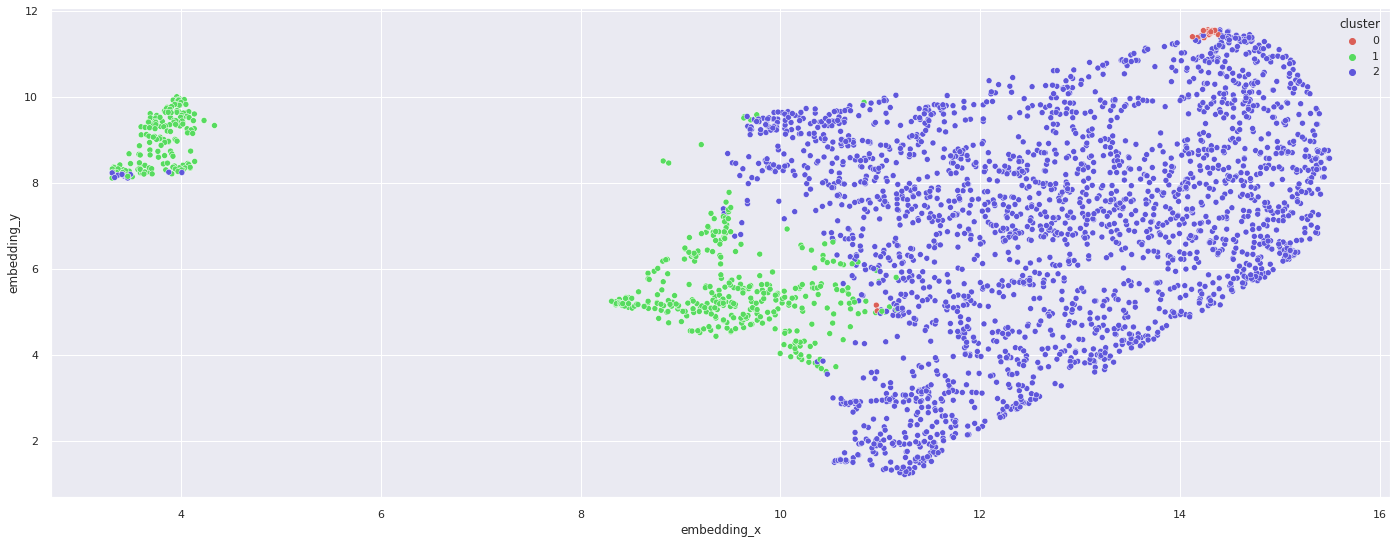

In [325]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform( X )

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz );

## 9.2. Cluster Profile

In [326]:
df9.head()

,customer_id,monetary,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,-35.50,17.00,40.00,50.97,0.62,1
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,-27.25,0.03,35.00,154.44,11.67,2
2,12583,6495.30,2.00,15.00,3796.00,221.00,29.39,-23.19,0.04,50.00,253.07,7.13,2
3,13748,938.89,95.00,5.00,415.00,27.00,34.77,-92.67,0.02,0.00,83.00,4.60,2
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,-8.60,0.07,22.00,26.67,0.33,1


In [330]:
# cluster - qt_users - per_user
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'qt_users'})
df_cluster['per_user'] = 100 * (df_cluster['qt_users'] / df_cluster['qt_users'].sum())


# monetary
monetary = df9[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, monetary, how='left', on='cluster')


# recency_days
recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, recency_days, how='left', on='cluster')

# qtde_invoices
qtde_invoices = df9[['qtde_invoices', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, qtde_invoices, how='left', on='cluster')

# qtde_products
qtde_products = df9[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, qtde_products, how='left', on='cluster')


# qtde_items
qtde_items = df9[['qtde_items', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, qtde_items, how='left', on='cluster')

# frequency
frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, frequency, how='left', on='cluster')

# qtde_returns
qtde_returns = df9[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, qtde_returns, how='left', on='cluster')



df_cluster

,cluster,qt_users,per_user,monetary,recency_days,qtde_invoices,qtde_products,qtde_items,frequency,qtde_returns
0,0,21,0.71,89214.90,31.38,60.95,1641.29,44366.76,0.22,1845.67
1,1,536,18.13,766.90,199.30,2.34,39.91,380.88,0.42,19.64
2,2,2399,81.16,2307.33,34.38,5.99,122.03,1228.69,0.04,19.29


# 10.0. Deploy to Product